# Numba: One way to speed up Python 🐍

# Brief definition

Ref:https://numba.pydata.org/

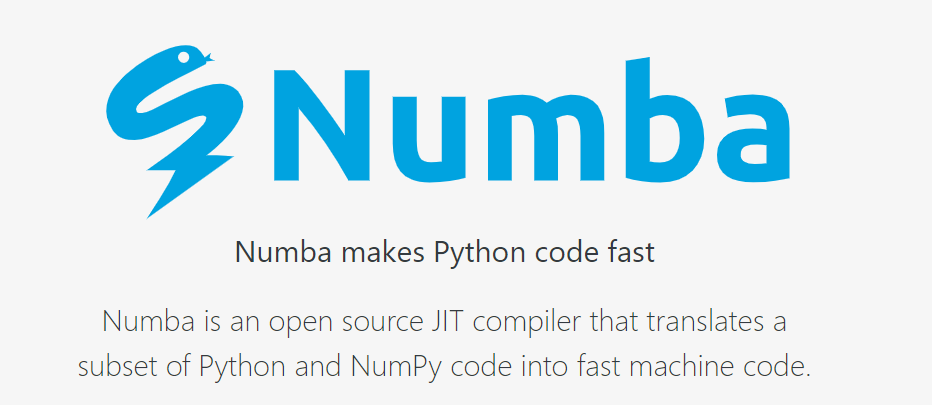

In [1]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

%matplotlib inline

# Outline

- How does Python work ? 
- How does Numba work ?
- Basic examples 
  - Sum of two matrices
  - JIT and it's parameters
  - How to debug Numba code (You cannot 😅 debug Numba)
  - Numba limitations
  - Honourable mentions - vectorize, Jitclass ...
- How to approach optimization with Numba
- Scientific exercises
  - Euclidian distance
  - Monte Carlo simulations
      - Calculation of $\pi$
  - Partial differential equations
      - Time-dependent 2D Schrodinger equation
  - Ordinary differential equationsfvc h 
      - Predator - Prey model

# How does Python work ?

Ref: https://medium.com/@kaushik.k/internal-working-of-python-415572929e7a

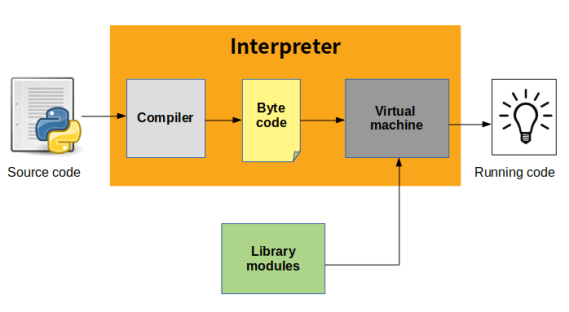

# How does Numba work ?

Ref: https://towardsdatascience.com/why-numba-sometime-way-slower-than-numpy-15d077390287

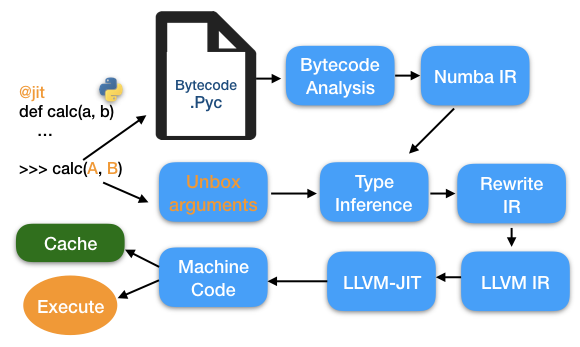

# Basic examples 

### Sum of two matrices

Using pure (inefficient) Python

In [51]:
A = np.array([[1, 1], [1, 1]])
B = np.array([[2, 2], [2, 2]])

def sum_matrices(A, B):
    C = np.zeros_like(A)
    m,n = A.shape
    for i in range(m):
        for j in range(n):
            C[i, j] = A[i, j] + B[i, j]
    return C

sum_matrices(A,B)

array([[3, 3],
       [3, 3]])

In [52]:
A = np.random.uniform(size=(2000,2000))
B = np.random.uniform(size=(2000,2000))
%timeit sum_matrices(A,B)

1.67 s ± 74.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using Numba JIT decorator

In [53]:
@nb.jit
def nb_sum_matrices(A, B):
    C = np.zeros_like(A)
    m,n = A.shape
    for i in range(m):
        for j in range(n):
            C[i, j] = A[i,j] + B[i, j]
    return C

In [54]:
%timeit nb_sum_matrices(A,B)

20.6 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Using just numpy 😊

In [55]:
%timeit A + B

15.4 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Using Numpy + Numba

In [56]:
@nb.jit
def nb_np_sum_matrices(A, B):
    return A + B

In [57]:
%timeit nb_np_sum_matrices(A,B)

16.2 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Similar graph of largness of arrays vs performance

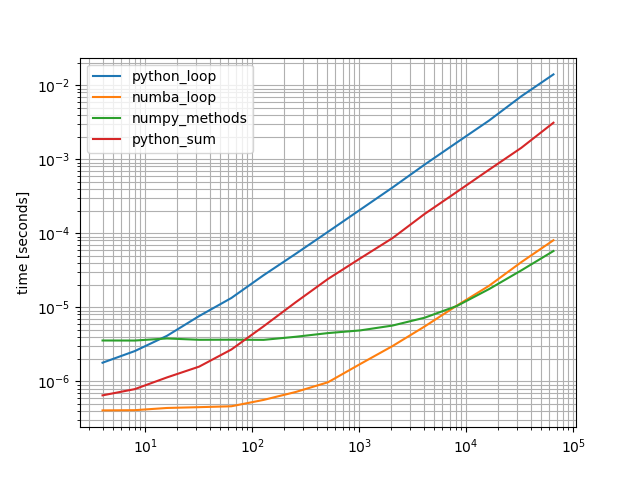

### JIT and it's parameters

- nopython :
    - False: object mode (default) - Numba compiler will generate code that can access the Python C API (slower but less likely to fail)
    - True: nopython mode - faster, cannot fallback to the Python C API
- nogil:
    - Whenever Numba optimizes Python code that only works on native types and variables (rather than Python objects), it is not necessary anymore to hold Python’s GIL
- cache: 
    - you can instruct Numba to write the result of function compilation into a file-based cache
- parallel: 
    - Enables automatic parallelization (and related optimizations) for those operations in the function known to have parallel semantics
- fastmath:
    - enables fast operations with primitive numeric types, if no precision rigor is needed
    - Numba will tell LLVM to use Intel Short Vector Math Library

### How to debug Numba code ?

There is no convenient way you can debug Numba code from Python Editor.\
After compilation of the selected Python code into LLVM machine code, the debugger won't go inside the body original Python source code and will execute the compiled code instead, leaving the breakpoints unseen.\
One possible workaround is to not use Numba, in case you would like to debug and swap JIT decorators with your custom ones

In [58]:
COMPILE_NUMBA = False # set this variable in some config file

def debuggable_jit(func=None, *, signature=None, fastmath=False, cache=False, parallel=False):
    '''
    decorator - if the numba compilation is turned on, returns the njit
    version of the function, otherwise the original function
    '''
    if func is None:
        return partial(debuggable_njit, signature=signature, fastmath=fastmath, cache=cache, parallel=parallel)

    if COMPILE_NUMBA:
        return nb.jit(signature, fastmath=fastmath, cache=cache, parallel=parallel)(func)

    return func

### Numba limitations

- can compile functions (or classes), but not the whole program (compared to PyPy)
- it doesnt support all Python or Numpy features
- OOP is a bit cumbersome
- cannot debug Numba code
- take Numba compilation time into account

### Honourable mentions

#### numba.vectorize
- For writing broadcasted universal functions (so called ufuncs)

In [59]:
@nb.vectorize([nb.float64(nb.float64, nb.float64)])
def vec_sum_matrices(a, b):
    return a + b

In [61]:
%timeit vec_sum_matrices(A,B)

17.1 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### numba.jitclass
- Numba supports code generation for classes via the numba.jitclass() decorator
- All methods of a jitclass are compiled into nopython functions
- The data of a jitclass instance is allocated on the heap as a C-compatible structure so that any compiled functions can have direct access to the underlying data, bypassing the interpreter

In [63]:
from numba import int32, float32    # import the types
from numba.experimental import jitclass

spec = [
    ('value', int32),               # a simple scalar field
    ('array', float32[:]),          # an array field
]

@jitclass(spec)
class Bag(object):
    def __init__(self, value):
        self.value = value
        self.array = np.zeros(value, dtype=np.float32)

    @property
    def size(self):
        return self.array.size

    def increment(self, val):
        for i in range(self.size):
            self.array[i] += val
        return self.array

    @staticmethod
    def add(x, y):
        return x + y

n = 21
mybag = Bag(n)

#### Checkout https://numba.pydata.org/ for more !

# Scientific exercises

Try to find fastest solutions for given exercises using Numba JIT \
You can use `%timeit` Jupyter line command for profiling

### Euclidean distance

Calculate euclidean distances between each point in given array

$$ s = \sqrt{\sum_{i=1}^{N}{(x_{i1}-x_{i2})^2}}$$

In [307]:
def distances(r):
    dim, N = r.shape
    s = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            s[j, i] = s[i, j] = np.sqrt(np.sum((r[:,i] - r[:,j])**2))
            
    return s

@nb.jit
def nb_distances(r):
    dim, N = r.shape
    s = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            s[j, i] = s[i, j] = np.sqrt(np.sum((r[:,i] - r[:,j])**2))
            
    return s

def np_distances(r):
    return np.sqrt(np.sum((r - r[np.newaxis,:,:].T)**2, axis=1))
    
@nb.jit
def nb_np_distances(r):
    return np.sqrt(np.sum((r - np.expand_dims(r,0).T)**2, axis=1))

In [308]:
r = np.array([[0,0], [1,1], [2,2]]).T
distances(r)

array([[0.        , 1.41421356, 2.82842712],
       [1.41421356, 0.        , 1.41421356],
       [2.82842712, 1.41421356, 0.        ]])

In [309]:
nb_distances(r)

array([[0.        , 1.41421356, 2.82842712],
       [1.41421356, 0.        , 1.41421356],
       [2.82842712, 1.41421356, 0.        ]])

In [310]:
np_distances(r)

array([[0.        , 1.41421356, 2.82842712],
       [1.41421356, 0.        , 1.41421356],
       [2.82842712, 1.41421356, 0.        ]])

In [311]:
nb_np_distances(r)

array([[0.        , 1.41421356, 2.82842712],
       [1.41421356, 0.        , 1.41421356],
       [2.82842712, 1.41421356, 0.        ]])

In [314]:
r = np.random.uniform(size=[2, 1000])

In [315]:
%timeit distances(r)

3.95 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [316]:
%timeit nb_distances(r)

55.2 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [317]:
%timeit np_distances(r)

21.3 ms ± 641 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [318]:
%timeit nb_np_distances(r)

14.7 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Monte Carlo simulations

### Calculation of $\pi$

Write Monte Carlo algorithm for calculation of $\pi$

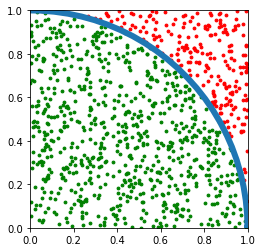

$$ r = 1$$
$$ \\\\$$
$$ n \sim \frac{\pi r^2}{4} =  \frac{\pi}{4}$$
$$ \\\\$$
$$ N \sim r^2 = 1$$
$$ \\\\$$
$$ \implies $$
$$ \pi \sim 4\frac{n}{N}$$

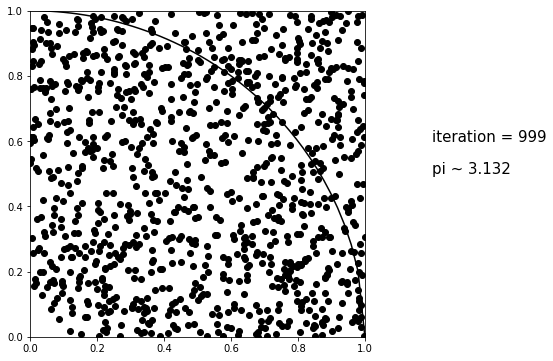

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

sims = 1000

N = 0.
n = 0.
randoms = np.zeros([2,sims])

for i in range(sims):
    
    N += 1.0
    rand = np.random.uniform(size=2)
    randoms[:,i] = rand
    if np.sum(rand**2) < 1.0:
        n += 1.0
    res = (4*n)/N
    
    ax.clear()
    ax.scatter(randoms[0,:], randoms[1,:], color = 'black')
    ax.plot(np.linspace(0,1), np.sqrt(1-np.linspace(0,1)**2), color='black')
    ax.set_xlim(0,1.)
    ax.set_ylim(0,1.)
    ax.text(1.2,0.5, f'pi ~ {res}', fontsize=15)
    ax.text(1.2,0.6, f'iteration = {i}', fontsize=15)
    display(fig)
    clear_output(wait=True)

In [41]:
# Python
def calc_pi(sims):
    N = 0.
    n = 0.
    randoms = np.zeros((2,sims))

    for i in range(sims):

        N += 1.0
        rand = np.random.uniform(0,1,2)
        randoms[:,i] = rand
        if np.sum(rand**2) < 1.0:
            n += 1.0
        res = (4*n)/N
    return res

# Numba + Python
@nb.njit
def nb_calc_pi(sims):
    N = 0.
    n = 0.
    randoms = np.zeros((2,sims))

    for i in nb.prange(sims):

        N += 1.0
        rand = np.random.uniform(0,1,2)
        randoms[:,i] = rand
        if np.sum(rand**2) < 1.0:
            n += 1.0
        res = (4*n)/N
    return res

# Numpy
def np_calc_pi(sims):
    return 4*np.sum(np.sum(np.random.uniform(0,1,size=(2,sims))**2, axis=0) < 1)/sims

# Numpy + Numba
@nb.njit
def nb_np_calc_pi(sims):
    return 4*np.sum(np.sum(np.random.uniform(0,1,size=(2,sims))**2, axis=0) < 1)/sims

In [42]:
%timeit calc_pi(10000)

99 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit nb_calc_pi(10000)

C:\Users\sead\Anaconda3\envs\numba-epd\lib\site-packages\numba\parfors\parfor_lowering.py:994: NumbaParallelSafetyWarning: Variable res used in parallel loop may be written to simultaneously by multiple workers and may result in non-deterministic or unintended results.

File "..\..\AppData\Local\Temp\ipykernel_16308\1982380370.py", line 24:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaParallelSafetyWarning(msg, loc))


143 µs ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%timeit np_calc_pi(10000)

205 µs ± 7.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
%timeit nb_np_calc_pi(10000)

171 µs ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Partial differential equations

Optimize numerical solution for Schrodinger equation using forward finite difference scheme 

$$i\hbar\frac{\partial \psi}{\partial t} =  -\frac{\hbar^2}{2m}\left(\frac{\partial^2 \psi}{{\partial x}^2} + \frac{\partial^2 \psi}{{\partial y}^2}\right) \implies -i\frac{\partial \psi}{\partial t} =  \frac{1}{2}\left(\frac{\partial^2 \psi}{{\partial x}^2} + \frac{\partial^2 \psi}{{\partial y}^2}\right)$$
$$\\\\$$
$$\psi_{i,j}^{k+1} = \psi_{i,j}^{k} -i\frac{\Delta t}{{\Delta x}^2}\left(\psi_{i+1,j}^{k} + \psi_{i-1,j}^{k} + \psi_{i,j+1}^{k} + \psi_{i,j-1}^{k} - 4\psi_{i,j}^{k}\right)$$

In [17]:
n = int(200)
m = int(400)
ts = int(50)
dt = 0.02
dx = 1
y = np.arange(n)*dx
x = np.arange(m)*dx
X,Y = np.meshgrid(x,y)

psi_mask = np.ones((n,m), dtype=np.int64)
psi_mask[0,:] = 0.
psi_mask[-1,:] = 0.
psi_mask[:,0] = 0.
psi_mask[:,-1] = 0.
psi_mask[:,190:200] = 0.
psi_mask[70:90,190:200] = 1.
psi_mask[110:130,190:200] = 1.

psi0 = np.exp(-((Y - 100.0)/5)**2)*np.exp(-((X - 100.0)/5)**2)*np.exp(-1j*1e9*X)

In [18]:
def calculate_schrodinger(psi, psi_mask, dx, dt, n, m, ts):
    for k in range(ts-1):
        for i in range(1,n-1):
            for j in range(1,m-1):
                if psi_mask[i,j]:
                    psi[i,j] = psi[i, j] - 1j*0.5*(dt/dx**2)*(psi[i+1,j] + psi[i-1,j] + psi[i, j+1] + psi[i, j-1] - 4*psi[i, j])
                else:
                    psi[i, j] = 0.
                    
        
    return  psi

schrodinger_signature = (nb.complex128[:,:],
                         nb.int64[:,:],
                         nb.float64,
                         nb.float64,
                         nb.int64,
                         nb.int64,
                         nb.int64)

@nb.njit(schrodinger_signature)
def nb_calculate_schrodinger(psi, psi_mask, dx, dt, n, m, ts):
    for k in range(ts-1):
        for i in range(1,n-1):
            for j in range(1,m-1):
                if psi_mask[i,j]:
                    psi[i,j] = psi[i, j] - 1j*0.5*(dt/dx**2)*(psi[i+1,j] + psi[i-1,j] + psi[i, j+1] + psi[i, j-1] - 4*psi[i, j])
                else:
                    psi[i, j] = 0.
                    
        
    return  psi


def np_calculate_schrodinger(psi, psi_mask, dx, dt, n, m, ts):
    for k in range(ts-1):
        psi[1:-1, 1:-1] = psi[1:-1, 1:-1] - 1j*0.5*(dt/dx**2)*(psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2] - 4*psi[1:-1, 1:-1])
        psi = psi*psi_mask    
    return  psi


@nb.njit(schrodinger_signature)
def nb_np_calculate_schrodinger(psi, psi_mask, dx, dt, n, m, ts):
    for k in range(ts-1):
        psi[1:-1, 1:-1] = psi[1:-1, 1:-1] - 1j*0.5*(dt/dx**2)*(psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2] - 4*psi[1:-1, 1:-1])
        psi = psi*psi_mask    
    return  psi

In [19]:
%timeit calculate_schrodinger(psi0, psi_mask, dx, dt, n, m, ts)

8.17 s ± 326 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit nb_calculate_schrodinger(psi0, psi_mask, dx, dt, n, m, ts)

42.7 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit np_calculate_schrodinger(psi0, psi_mask, dx, dt, n, m, ts)

408 ms ± 81.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%timeit nb_np_calculate_schrodinger(psi0, psi_mask, dx, dt, n, m, ts)

124 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


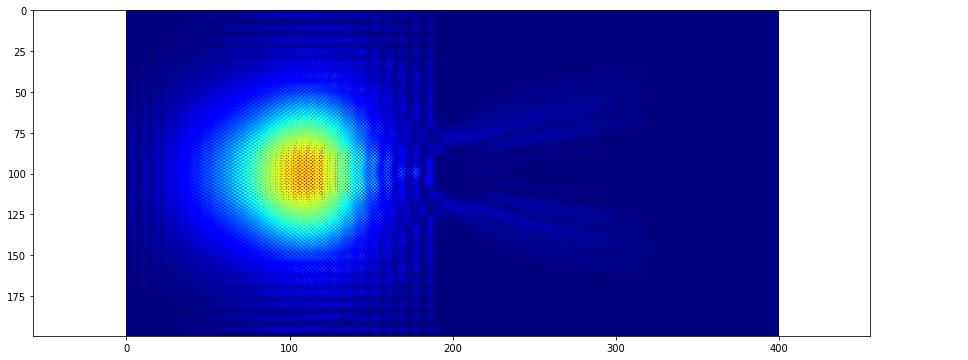

In [27]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
psi0 = np.exp(-((Y - 100.0)/5)**2)*np.exp(-((X - 100.0)/5)**2)*np.exp(-1j*1e9*X)

psi = psi0
for i in range(250):
    psi = nb_np_calculate_schrodinger(psi, psi_mask, dx, dt, n, m, ts)
    ax.clear()
    ax.imshow(abs(psi)**2, cmap='jet')
    ax.text(500,100, i, color='white')
    ax.axis('equal')
    display(fig)
    clear_output(wait=True)

# Ordinary differential equations

$$\frac{d\textbf{v}}{dt} = \textbf{f}(v,t) $$
$$\\\\ $$
Euler approximation
$$\frac{\textbf{v}_{i+1} - \textbf{v}_{i} }{\Delta t} \approx  \textbf{f}(\textbf{v}_{i},t_i) \implies v_{i+1} \approx v_{i} + \textbf{f}(\textbf{v}_{i},t_i)\Delta t $$
$$\\\\ $$
Runge-Kutta approximation
$$ \textbf{K}_1 = \textbf{f}(\textbf{v}_{i},t_i)$$
$$ \textbf{K}_2 = \textbf{f}(\textbf{v}_{i} + \frac{1}{2}\textbf{K}_1\Delta t,t_i + \frac{1}{2}\Delta t)$$
$$ \textbf{K}_3 = \textbf{f}(\textbf{v}_{i} + \frac{1}{2}\textbf{K}_2\Delta t,t_i + \frac{1}{2}\Delta t)$$
$$ \textbf{K}_4 = \textbf{f}(\textbf{v}_{i} + \textbf{K}_3\Delta t,t_i + \Delta t)$$
$$\\\\ $$
$$ \textbf{v}_{i+1} \approx \textbf{v}_{i} + \frac{1}{6}(\textbf{K}_1 + 2\textbf{K}_2 + 2\textbf{K}_3 + \textbf{K}_4)\Delta t $$

### Predator - Prey model - Lotka-Volterra approach

$$\frac{d{H}}{dt} = C_1{P}{H} - C_2{H}  $$
$$\frac{d{P}}{dt} = -C_3{P}{H} + C_4{P} $$

In [30]:
def runge_kutta_integrator(t,f,x0):
    
    dts = t[1:]-t[:-1]
    solution = np.zeros([t.size, x0.size])
    solution[0] = x0
    
    for i, dt in enumerate(dts):
        K1 = f(solution[i], t[i])
        K2 = f(solution[i] + 0.5*K1*dt, t[i] + 0.5*dt)
        K3 = f(solution[i] + 0.5*K2*dt, t[i] + 0.5*dt)
        K4 = f(solution[i] + K3*dt, t[i] + dt)
        
        solution[i+1] = solution[i] + (1./6.)*(K1 + 2*K2 + 2*K3 + K4)*dt
        
    return solution

def Lotka_Volterra_model(x,t):
    
    f = np.zeros_like(x)
    f[0] = 1e-4*x[0]*x[1] - 0.02*x[0]
    f[1] = -2e-4*x[0]*x[1] + 0.05*x[1]
    
    return f

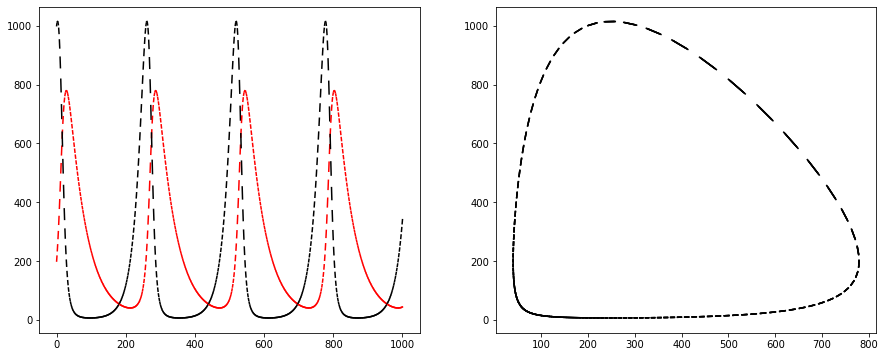

In [31]:
t = np.linspace(0,1000,1000)
population0 = np.array([200,1000])
population = runge_kutta_integrator(t, Lotka_Volterra_model, population0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for i, time in enumerate(t):
    
    ax[0].plot(t[2*i:2*i+2], population[2*i:2*i+2,0], color='red')
    ax[0].plot(t[2*i:2*i+2], population[2*i:2*i+2,1], color='black')
    
    ax[1].plot(population[2*i:2*i+2,0], population[2*i:2*i+2,1], color='black')
    
    display(fig)
    clear_output(wait=True)

In [8]:
%timeit runge_kutta_integrator(t, Lotka_Volterra_model, population0)

31.6 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
@nb.njit
def nb_runge_kutta_integrator(t,f,x0):
    
    dts = t[1:]-t[:-1]
    solution = np.zeros((t.size, x0.size))
    solution[0] = x0
    
    for i, dt in enumerate(dts):
        K1 = f(solution[i], t[i])
        K2 = f(solution[i] + 0.5*K1*dt, t[i] + 0.5*dt)
        K3 = f(solution[i] + 0.5*K2*dt, t[i] + 0.5*dt)
        K4 = f(solution[i] + K3*dt, t[i] + dt)
        
        solution[i+1] = solution[i] + (1./6.)*(K1 + 2*K2 + 2*K3 + K4)*dt
        
    return solution

@nb.njit
def nb_Lotka_Volterra_model(x,t):
    
    f = np.zeros_like(x)
    f[0] = 1e-4*x[0]*x[1] - 0.02*x[0]
    f[1] = -2e-4*x[0]*x[1] + 0.05*x[1]
    
    return f

In [10]:
%timeit runge_kutta_integrator(t, nb_Lotka_Volterra_model, population0)

19.4 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit nb_runge_kutta_integrator(t, nb_Lotka_Volterra_model, population0)

779 µs ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
from scipy.integrate import odeint

In [15]:
%timeit odeint(nb_Lotka_Volterra_model, population0, t)

1.71 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
